# L5: Fast AI Agents with a Semantic Cache

In this final lab, you’ll integrate your semantic cache into an AI agent so it can reuse past results, skip redundant work, and get faster over time.

<p style="background-color:#fff6e4; padding:15px; border-width:3px; border-color:#f5ecda; border-style:solid; border-radius:6px"> ⏳ <b>Note <code>(Kernel Starting)</code>:</b> This notebook takes about 30 seconds to be ready to use. You may start and watch the video while you wait.</p>

In [1]:
# Warning control
import warnings
warnings.filterwarnings('ignore')

## Setup Environment

In [2]:
# Choose your LLM provider: 'openai' or 'gemini'
import os
os.environ['LLM_PROVIDER'] = 'openai'  # Change to 'gemini' to use Gemini models

# Set up API keys based on provider
from cache.llm_evaluator import set_openai_key, set_google_key

if os.getenv('LLM_PROVIDER', 'openai') == 'gemini':
    set_google_key()
    print('✓ Using Gemini models')
else:
    set_openai_key()
    print('✓ Using OpenAI models')

✓ Using OpenAI models


In [3]:
import logging
import time
import json
import numpy as np
import pandas as pd
from datetime import datetime
from typing import List, Dict, Any, Optional

from langchain.schema import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langgraph.graph import StateGraph, END, START

import redis
from redisvl.utils.vectorize import HFTextVectorizer, OpenAITextVectorizer
from redisvl.extensions.cache.llm import SemanticCache
from redisvl.index import SearchIndex
from redisvl.query import VectorQuery

logging.basicConfig(
    level=logging.INFO, format="%(asctime)s | %(levelname)s | %(message)s"
)
logger = logging.getLogger("agentic-workflow")

### Model Selection

This notebook supports both **OpenAI** and **Google Gemini** models. You can switch between providers by changing the `LLM_PROVIDER` environment variable in the cell above:

- Set `LLM_PROVIDER = 'openai'` to use OpenAI models (GPT-4o, GPT-4o-mini)
- Set `LLM_PROVIDER = 'gemini'` to use Google Gemini models (Gemini 2.0 Flash)

Make sure you have the corresponding API key set in your `.env` file:
- For OpenAI: `OPENAI_API_KEY`
- For Gemini: `GOOGLE_API_KEY`

### Model Selection

This notebook supports both **OpenAI** and **Google Gemini** models. You can switch between providers by changing the `LLM_PROVIDER` environment variable in the cell above:

- Set `LLM_PROVIDER = 'openai'` to use OpenAI models (GPT-4o, GPT-4o-mini)
- Set `LLM_PROVIDER = 'gemini'` to use Google Gemini models (Gemini 2.0 Flash)

Make sure you have the corresponding API key set in your `.env` file:
- For OpenAI: `OPENAI_API_KEY`
- For Gemini: `GOOGLE_API_KEY`

<div style="background-color:#fff6ff; padding:13px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px">
<p> 💻 &nbsp; <b>Access <code>requirements.txt</code> and <code>helper.py</code> files:</b> 1) click on the <em>"File"</em> option on the top menu of the notebook and then 2) click on <em>"Open"</em>.

<p> ⬇ &nbsp; <b>Download Notebooks:</b> 1) click on the <em>"File"</em> option on the top menu of the notebook and then 2) click on <em>"Download as"</em> and select <em>"Notebook (.ipynb)"</em>.</p>
</div>

## Setup Redis Infra

In [4]:
redis_client = redis.Redis.from_url(
    "redis://localhost:6379", decode_responses=False
)
redis_client.ping()

True

### Build the Agent Knowledge Base (for RAG)


In [5]:
from agent import create_knowledge_base_from_texts


embeddings = OpenAITextVectorizer()

raw_docs = [
    "Our premium support plan includes 24/7 phone support, priority email response within 2 hours, and dedicated account management. Premium support costs $49/month.",
    "Account upgrade process: Go to Account Settings → Plan & Billing → Select Upgrade. Available plans: Basic $9/month, Pro $29/month, Enterprise $99/month.",
    "API rate limits by plan: Free tier 100 requests/hour, Basic 1,000 requests/hour, Pro 10,000 requests/hour, Enterprise unlimited with fair-use policy.",
    "Data export options: CSV, JSON, XML formats supported. Large exports (>1GB) may take up to 24 hours to process.",
    "Third-party integrations: Native support for Slack, Microsoft Teams, Zoom, Salesforce, HubSpot. 200+ additional integrations available via Zapier.",
    "Security features: SOC2 compliance, end-to-end encryption, GDPR compliance, SSO integration, audit logs, IP whitelisting.",
    "Billing and payments: We accept all major credit cards, PayPal, and ACH transfers. Enterprise customers can pay by invoice with NET30 terms.",
    "Account recovery: Use forgot password link, verify email, or contact support with account verification details. Response within 4 hours.",
]

success, message, kb_index = create_knowledge_base_from_texts(
    texts=raw_docs,
    source_id="customer_support_docs",
    redis_url="redis://localhost:6379",
    skip_chunking=True
)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:kb-utils:Using provided list of 8 text chunks
INFO:redisvl.index.index:Index already exists, overwriting.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:kb-utils:✅ Created knowledge base 

### Build the Semantic Cache

In [6]:
from cache.wrapper import SemanticCacheWrapper
from cache.config import config
from cache.cross_encoder import CrossEncoder
from cache.faq_data_container import FAQDataContainer

cache = SemanticCacheWrapper.from_config(config)

data = FAQDataContainer()
cache.hydrate_from_df(data.faq_df, clear=True)

✅ Redis is running and accessible!


INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda:0
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: redis/langcache-embed-v1
INFO:redisvl.index.index:Index already exists, not overwriting.


Loaded 8 FAQ entries
Loaded 80 test queries


## Build the LangGraph Agent

In [7]:
from agent import (
    WorkflowState,
    initialize_agent,
    decompose_query_node,
    check_cache_node,
    research_node,
    evaluate_quality_node,
    synthesize_response_node,
    route_after_cache_check,
    route_after_quality_evaluation,
)

initialize_agent(cache, kb_index, embeddings)

In [8]:
workflow = StateGraph(WorkflowState)

# Add nodes 
workflow.add_node("decompose_query", decompose_query_node)
workflow.add_node("check_cache", check_cache_node)
workflow.add_node("research", research_node)
workflow.add_node("evaluate_quality", evaluate_quality_node)
workflow.add_node("synthesize", synthesize_response_node)

# Set entry point to decomposition node
workflow.set_entry_point("decompose_query")

# Add edges
workflow.add_edge("decompose_query", "check_cache")
workflow.add_conditional_edges(
    "check_cache",
    route_after_cache_check,
    {
        "research": "research",  # Go to research if cache misses
        "synthesize": "synthesize",  # Skip to synthesis if all cached
    },
)
workflow.add_edge("research", "evaluate_quality")
workflow.add_conditional_edges(
    "evaluate_quality",
    route_after_quality_evaluation,
    {
        "research": "research",
        "synthesize": "synthesize",
    },
)
workflow.add_edge("synthesize", END)

workflow_app = workflow.compile()

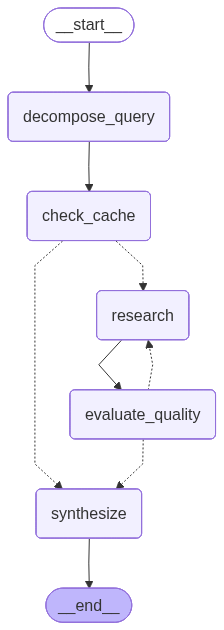

In [9]:
from IPython.display import Image, display

display(Image(workflow_app.get_graph().draw_mermaid_png()))

## Demo the Agent

<p style="background-color:#f7fff8; padding:15px; border-width:3px; border-color:#e0f0e0; border-style:solid; border-radius:6px"> 🚨
&nbsp; <b>Different Run Results:</b> The output visualizations generated may differ from those shown in the video.</p>

In [10]:
from agent import display_results
from agent import run_agent

### Scenario 1: Enterprise Platform Evaluation (cache building phase)


In [11]:
scenario1_query = """
I'm evaluating your platform for our enterprise needs. We need to understand your 
security and compliance standards including SOC2 status, want to know the API rate 
limits for the Pro plan since we're considering that tier, need details about 
Salesforce integration capabilities, and want to understand your payment options 
including whether you support ACH transfers.
"""

result1 = run_agent(workflow_app, scenario1_query)
display_results(result1)

INFO:agentic-workflow:================================================================================
INFO:agentic-workflow:🧠 Decomposing query...
INFO:agentic-workflow:🧠 Supervisor: Decomposing query: '
I'm evaluating your platform for our enterprise n...'
INFO:cache.model_factory:Creating OpenAI analysis LLM with model gpt-4o
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:agentic-workflow:🧠 Decomposed into 4 sub-questions in 1288.79ms
INFO:agentic-workflow:   1. What are your security and compliance standards, including SOC2 status?
INFO:agentic-workflow:   2. What are the API rate limits for the Pro plan?
INFO:agentic-workflow:   3. What are the details about your Salesforce integration capabilities?
INFO:agentic-workflow:   4. What are your payment options, and do you support ACH transfers?
INFO:agentic-workflow:🧠 Query decomposition complete
INFO:agentic-workflow:🔍 Supervisor: Checking cache for 4 sub-questions
INFO:agentic-workflo

\n🎯 SEMANTIC CACHING WORKFLOW ANALYSIS
📝 **Original Query:** 
I'm evaluating your platform for our enterprise needs. We need to understand your 
security and com...
🔄 **Execution Path:** decomposed → cache_checked → researched → quality_evaluated → synthesized
\n🧠 **Query Decomposition:** 4 sub-questions
   1. 🔍 **RESEARCH**: What are your security and compliance standards, including SOC2 status?
   2. 🔍 **RESEARCH**: What are the API rate limits for the Pro plan?
   3. 🔍 **RESEARCH**: What are the details about your Salesforce integration capabilities?
   4. ✅ **CACHE HIT** (0.891): What are your payment options, and do you support ACH transfers?
\n📊 **Performance Metrics:**
   💾 Cache Hit Rate: **25.0%** (1/4 questions)
   🤖 LLM Calls: **8** (GPT-4: 2, GPT-4-Mini: 6)
   ⚡ Total Latency: **29976.59ms**
   ⏱️  Cache: 204ms, Research: 15279ms
\n📋 **AI Response:**
--------------------------------------------------------------------------------


Thank you for considering our platform for your enterprise needs. I'm happy to provide you with the information you need to make an informed decision.

Regarding our security and compliance standards, we adhere to the SOC2 framework, ensuring that we manage customer data securely and protect our clients' interests. We also implement end-to-end encryption for data in transit and at rest, comply with GDPR for privacy protection, and offer Single Sign-On (SSO) integration for secure access management. Additionally, we maintain comprehensive audit logs and support IP whitelisting to enhance security.

For the Pro plan, our API rate limits are set at 10,000 requests per hour, which should accommodate a wide range of enterprise needs.

In terms of Salesforce integration, we offer native support for seamless data exchange and interaction. Our platform also supports integrations with other popular services like Slack, Microsoft Teams, and Zoom. Furthermore, through Zapier, you can access over 200 additional integrations, expanding your connectivity options.

As for payment options, we accept all major credit cards, PayPal, Apple Pay, Google Pay, and bank transfers for orders over $100. However, we currently do not support ACH transfers.

If you have any more questions or need further clarification, please feel free to reach out. We're here to help!

--------------------------------------------------------------------------------


### Scenario 2: Implementation Planning (partial cache hits likely)

In [12]:
scenario2_query = """
We're moving forward with implementation planning. I need to compare API rate limits 
between Pro and Enterprise plans to decide on our tier, confirm the Salesforce 
integration capabilities we discussed, understand what data export options you provide 
for our migration needs, and verify the payment methods including ACH since our 
accounting team prefers that for monthly billing.
"""

result2 = run_agent(workflow_app, scenario2_query)
display_results(result2)

INFO:agentic-workflow:================================================================================
INFO:agentic-workflow:🧠 Decomposing query...
INFO:agentic-workflow:🧠 Supervisor: Decomposing query: '
We're moving forward with implementation planning...'
INFO:cache.model_factory:Creating OpenAI analysis LLM with model gpt-4o
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:agentic-workflow:🧠 Decomposed into 4 sub-questions in 1080.60ms
INFO:agentic-workflow:   1. Compare API rate limits between Pro and Enterprise plans to decide on our tier.
INFO:agentic-workflow:   2. Confirm the Salesforce integration capabilities we discussed.
INFO:agentic-workflow:   3. Understand what data export options you provide for our migration needs.
INFO:agentic-workflow:   4. Verify the payment methods including ACH since our accounting team prefers that for monthly billing.
INFO:agentic-workflow:🧠 Query decomposition complete
INFO:agentic-workflow:🔍 Supe

\n🎯 SEMANTIC CACHING WORKFLOW ANALYSIS
📝 **Original Query:** 
We're moving forward with implementation planning. I need to compare API rate limits 
between Pro a...
🔄 **Execution Path:** decomposed → cache_checked → researched → quality_evaluated → synthesized
\n🧠 **Query Decomposition:** 4 sub-questions
   1. ✅ **CACHE HIT** (0.885): Compare API rate limits between Pro and Enterprise plans to decide on our tier.
   2. ✅ **CACHE HIT** (0.913): Confirm the Salesforce integration capabilities we discussed.
   3. 🔍 **RESEARCH**: Understand what data export options you provide for our migration needs.
   4. 🔍 **RESEARCH**: Verify the payment methods including ACH since our accounting team prefers that for monthly billing.
\n📊 **Performance Metrics:**
   💾 Cache Hit Rate: **50.0%** (2/4 questions)
   🤖 LLM Calls: **6** (GPT-4: 2, GPT-4-Mini: 4)
   ⚡ Total Latency: **15537.80ms**
   ⏱️  Cache: 210ms, Research: 5700ms
\n📋 **AI Response:**
------------------------------------------------------

Hello! It sounds like you're gearing up for an important decision regarding your implementation planning, and I'm here to help clarify the details for you.

Firstly, regarding the API rate limits, the Pro plan offers 10,000 requests per hour. If you're considering the Enterprise plan, it typically provides higher limits, but I recommend contacting our sales team for the exact figures to ensure it meets your needs.

For Salesforce integration, we offer robust capabilities including native support for seamless data exchange and interaction. Additionally, we support third-party integrations with platforms like Slack, Microsoft Teams, and Zoom. If you require even more connectivity, there are over 200 additional integrations available through Zapier. Should you need more specific details about these integrations, please let me know!

When it comes to data export options for your migration needs, we support CSV, JSON, and XML formats. Please note that large exports over 1GB might take up to 24 hours to process, so planning ahead would be beneficial.

Lastly, regarding payment methods, we accept all major credit cards, PayPal, and ACH transfers, which should suit your accounting team's preference for monthly billing. Enterprise customers also have the option to pay by invoice with NET30 terms.

If you have any more questions or need further assistance, feel free to reach out. I'm here to help make your transition as smooth as possible!

--------------------------------------------------------------------------------


### Scenario 3: Pre-Purchase Comprehensive Review (many cache hits expected)

In [13]:
scenario3_query = """
Before finalizing our Pro plan purchase, I need complete validation on: your security 
compliance framework including SOC2 requirements, the exact API rate limits for the 
Pro plan we're purchasing, confirmation of the Salesforce integration features, all 
supported payment methods since we want to use ACH transfers, and your data export 
capabilities for our future migration planning.
"""

result3 = run_agent(workflow_app, scenario3_query)
display_results(result3)

INFO:agentic-workflow:================================================================================
INFO:agentic-workflow:🧠 Decomposing query...
INFO:agentic-workflow:🧠 Supervisor: Decomposing query: '
Before finalizing our Pro plan purchase, I need c...'
INFO:cache.model_factory:Creating OpenAI analysis LLM with model gpt-4o
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:agentic-workflow:🧠 Decomposed into 4 sub-questions in 1248.17ms
INFO:agentic-workflow:   1. Your security compliance framework including SOC2 requirements.
INFO:agentic-workflow:   2. The exact API rate limits for the Pro plan we're purchasing.
INFO:agentic-workflow:   3. Confirmation of the Salesforce integration features.
INFO:agentic-workflow:   4. All supported payment methods since we want to use ACH transfers.
INFO:agentic-workflow:🧠 Query decomposition complete
INFO:agentic-workflow:🔍 Supervisor: Checking cache for 4 sub-questions
INFO:agentic-workflow:   ✅ Ca

\n🎯 SEMANTIC CACHING WORKFLOW ANALYSIS
📝 **Original Query:** 
Before finalizing our Pro plan purchase, I need complete validation on: your security 
compliance f...
🔄 **Execution Path:** decomposed → cache_checked → synthesized
\n🧠 **Query Decomposition:** 4 sub-questions
   1. ✅ **CACHE HIT** (0.953): Your security compliance framework including SOC2 requirements.
   2. ✅ **CACHE HIT** (0.978): The exact API rate limits for the Pro plan we're purchasing.
   3. ✅ **CACHE HIT** (0.896): Confirmation of the Salesforce integration features.
   4. ✅ **CACHE HIT** (0.853): All supported payment methods since we want to use ACH transfers.
\n📊 **Performance Metrics:**
   💾 Cache Hit Rate: **100.0%** (4/4 questions)
   🤖 LLM Calls: **2** (GPT-4: 2, GPT-4-Mini: 0)
   ⚡ Total Latency: **6810.01ms**
   ⏱️  Cache: 138ms, Research: 0ms
\n📋 **AI Response:**
--------------------------------------------------------------------------------


Thank you for reaching out with your questions before finalizing your Pro plan purchase. I'm happy to provide you with the information you need.

Firstly, regarding our security compliance framework, we adhere to the SOC2 standards, ensuring that we manage customer data securely and protect your interests. Our security measures include end-to-end encryption, GDPR compliance, single sign-on (SSO) integration, comprehensive audit logs, and IP whitelisting to maintain a high level of security and compliance.

For the Pro plan, the API rate limits are set at 10,000 requests per hour, which should support your needs effectively.

In terms of Salesforce integration, we offer native support for seamless data exchange and interaction. Additionally, we provide integration capabilities with other platforms like Slack, Microsoft Teams, and Zoom, along with over 200 more integrations available through Zapier.

Regarding payment methods, we accept all major credit cards, PayPal, Apple Pay, Google Pay, and bank transfers for orders over $100. Unfortunately, ACH transfers are not currently supported.

Lastly, for your data export needs, our platform offers robust data export capabilities to assist with future migration planning.

If you have any more questions or need further clarification, feel free to ask. We're here to help!

--------------------------------------------------------------------------------


## Agent Performance Analysis


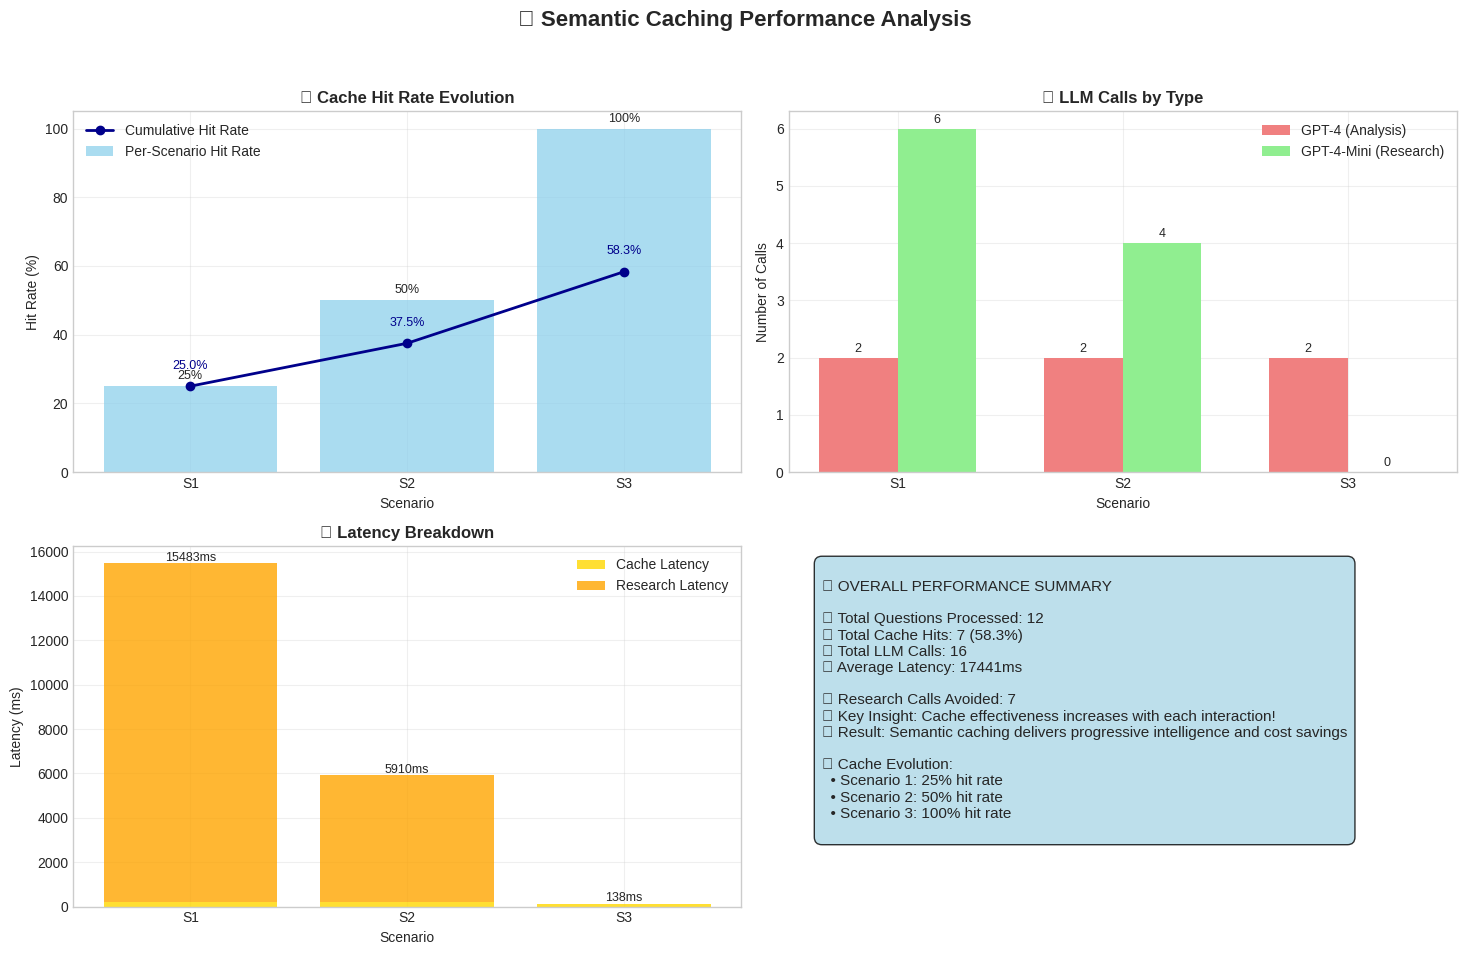

In [14]:
import warnings
warnings.simplefilter("ignore")

from agent import analyze_agent_results

total_questions, total_cache_hits = analyze_agent_results(
    [result1, result2, result3]
)

## Interactive Demo


Here is the link we used in the video for this section:
* https://att.com/international
    * example query: I have a cruise trip coming up and what to make sure that my cell phone coverage through ATT will work while on the cruise. Will it be ok?

In [15]:
from agent import launch_demo

launch_demo(
    workflow_app,
    cache,
    share=True,
    height=1500,
    inline=True
)

INFO:demo:Using Tavily API key from environment
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET http://127.0.0.1:7860/gradio_api/startup-events "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: HEAD http://127.0.0.1:7860/ "HTTP/1.1 200 OK"


* Running on local URL:  http://127.0.0.1:7860


INFO:httpx:HTTP Request: GET https://api.gradio.app/pkg-version "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.gradio.app/v3/tunnel-request "HTTP/1.1 200 OK"


* Running on public URL: https://5d757439bd4d155c5e.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


INFO:httpx:HTTP Request: HEAD https://5d757439bd4d155c5e.gradio.live "HTTP/1.1 200 OK"


In [17]:
cache.cache.check(
    "checking cache", distance_threshold=1.0, num_results=100
)

[{'entry_id': '8403303d83388df01069bbb9c5cba44753eab36d50efec544c1cb5549b3e31bb',
  'prompt': 'I have a cruise trip coming up and what to make sure that my cell phone coverage through ATT will work while on the cruise. Will it be ok?',
  'response': "Yes, your AT&T cell phone coverage should work while you're on the cruise. AT&T offers an International Day Pass that allows you to use your phone on land and on over 400 cruise ships. The cost is $20 per day for cruise usage. \n\nKeep in mind that coverage may not be available in all areas, and terms, data allowances, and fees may apply. It's a good idea to check with AT&T for any specific details related to your cruise itinerary.",
  'vector_distance': 0.579822421074,
  'inserted_at': 1763968074.11,
  'updated_at': 1763968074.11,
  'key': 'semantic-cache:8403303d83388df01069bbb9c5cba44753eab36d50efec544c1cb5549b3e31bb'}]